In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, Input, Lambda, GlobalAveragePooling2D, Concatenate, PReLU, LeakyReLU, Embedding, multiply
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
import os
from os import listdir
from tqdm import tqdm
import shutil
import cv2
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import time
import itertools
from sklearn.utils import resample  # Import resample
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
# TensorFlow and Keras versions
print(tf.__version__)
print(tf.keras.__version__)

2.16.2
3.4.1


In [4]:
# Callbacks
epochs = 125

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=epochs,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger('Model.log')

callbacks = [earlystop, csv_logger, reduce_lr]


In [5]:
# Intersection over Union (IoU)
def iou(y_true, y_pred, smooth=0.5):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [6]:
# Computing Sensitivity
def sensitivity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [7]:
# Computing Specificity
def specificity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


In [8]:
# Computing f1-score
def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [9]:
# Define Dice coefficient metric
def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    dice_score = (2.0 * intersection + epsilon) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + epsilon)
    return dice_score

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)

def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

In [10]:
def confusion_matrix_img(y_pred, y_true, savename):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['benign', 'malignant']
    title='Confusion matrix'
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(savename)
    plt.show()

In [11]:
# Creating the directories for augmented data
size = 128
os.makedirs('augmented/benign', exist_ok=True)
os.makedirs('augmented/malignant', exist_ok=True)

def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

In [12]:
# Copying benign images to the augmented directory
files_benign = getListOfFiles('/Users/renitalewis/Downloads/archive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign')
for f in files_benign:
    if f.endswith('.png'):
        shutil.copy(f, 'augmented/benign')

In [13]:
# Copying malignant images to the augmented directory
files_malignant = getListOfFiles('/Users/renitalewis/Downloads/archive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant')
for f in files_malignant:
    if f.endswith('.png'):
        shutil.copy(f, 'augmented/malignant')

In [14]:
benign_images = getListOfFiles('augmented/benign')
malignent_images = getListOfFiles('augmented/malignant')

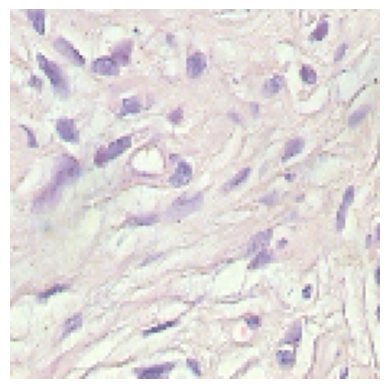

In [15]:
# Load and display an image
image_path = benign_images[9]
img = load_img(image_path, target_size=(size, size), color_mode='rgb')
img_array = img_to_array(img)
plt.imshow(img_array.astype('uint8'))
plt.axis('off')
plt.show()

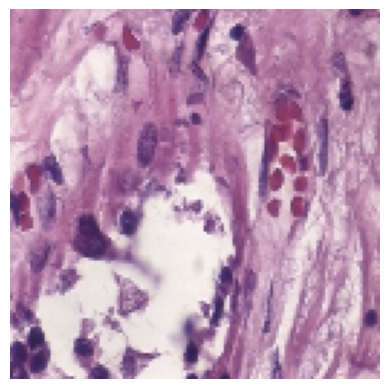

In [16]:
# Load and display another image
image_path = malignent_images[45]
img = load_img(image_path, target_size=(size, size), color_mode='rgb')
img_array = img_to_array(img)
plt.imshow(img_array.astype('uint8'))
plt.axis('off')
plt.show()

In [17]:
# Preparing the DataFrame
total_images = len(benign_images) + len(malignent_images)
data = pd.DataFrame(index=np.arange(0, total_images), columns=["image", "target"])

k = 0
for c, image_list in enumerate([benign_images, malignent_images]):
    for image_path in image_list:
        data.loc[k, "image"] = image_path
        data.loc[k, "target"] = c
        k += 1

print(data.shape)
print(data.head())

count_data = data["target"].value_counts()
ben_upsampled = resample(data[data['target']==0], n_samples=data[data['target']==1].shape[0], random_state=42)
up_sampled = pd.concat([data[data['target']==1], ben_upsampled])
up_sampled['target'].value_counts()

(7909, 2)
                                             image target
0  augmented/benign/SOB_B_F-14-23060CD-100-001.png      0
1  augmented/benign/SOB_B_TA-14-19854C-200-016.png      0
2  augmented/benign/SOB_B_TA-14-19854C-200-002.png      0
3    augmented/benign/SOB_B_F-14-25197-400-039.png      0
4   augmented/benign/SOB_B_F-14-14134E-100-007.png      0


target
1    5429
0    5429
Name: count, dtype: int64

In [18]:
# The Corrected loop to load images
train_image = []
y = []

for i in tqdm(range(up_sampled.shape[0])):
    img = tf.keras.utils.load_img(up_sampled['image'].iloc[i], target_size=(size, size), color_mode='rgb')
    img = tf.keras.utils.img_to_array(img)
    img = img / 255.0
    train_image.append(img)
        
X = np.array(train_image)
y = up_sampled.iloc[:, -1].values

100%|████████████████████████████████████| 10858/10858 [01:05<00:00, 166.16it/s]


In [19]:
# KFold split
kf = KFold(n_splits=10, random_state=42, shuffle=True)

for train_index, test_index in kf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

for train_index, test_index in kf.split(X_test, y_test):
    X2_test, X_val, y2_test, y_val = X_test[train_index], X_test[test_index], y_test[train_index], y_test[test_index]

Y_train = to_categorical(y_train, 2)
Y_test = to_categorical(y2_test, 2)
Y_val = to_categorical(y_val, 2)

print(X_train.shape)
print(X2_test.shape)
print(X_val.shape)

data_gen = ImageDataGenerator(
    zoom_range=1.2,  # set range for random zoom
    rotation_range=90,
    width_shift_range=0.5,
    height_shift_range=0.5,
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,  # randomly flip images
)

data_gen.fit(X_train)
data_gen.fit(X_val)
data_gen.fit(X2_test)

(9773, 128, 128, 3)
(977, 128, 128, 3)
(108, 128, 128, 3)


In [20]:
# WGAN-GP Loss functions
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

def gradient_penalty_loss(y_true, y_pred, averaged_samples, lambda_gp):
    gradients = K.gradients(y_pred, averaged_samples)[0]
    gradients_sqr = K.square(gradients)
    gradient_penalty = K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))
    return K.mean((gradient_penalty - 1.0) ** 2) * lambda_gp

In [21]:
# ACGAN-WGAN-GP Architecture
def build_generator(noise_dim, num_classes, img_shape):
    noise = Input(shape=(noise_dim,))
    label = Input(shape=(1,), dtype='int32')
    
    label_embedding = Flatten()(Embedding(num_classes, noise_dim)(label))
    model_input = multiply([noise, label_embedding])
    
    x = Dense(256)(model_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(np.prod(img_shape), activation='tanh')(x)
    img = Reshape(img_shape)(x)
    
    return Model([noise, label], img)

def build_discriminator(img_shape, num_classes):
    img = Input(shape=img_shape)
    
    x = Flatten()(img)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    validity = Dense(1, name='validity')(x)
    label = Dense(num_classes, activation='softmax', name='label')(x)
    
    return Model(img, [validity, label])

In [22]:
# Setting image shape and noise dimension
img_shape = (size, size, 3)
noise_dim = 100
num_classes = 2
lambda_gp = 10  # Gradient penalty lambda hyperparameter

In [23]:
# Building and compiling the discriminator
discriminator = build_discriminator(img_shape, num_classes)
discriminator.compile(loss={'validity': wasserstein_loss, 'label': 'sparse_categorical_crossentropy'},
                      optimizer=Adam(0.0002, 0.5),
                      metrics={'label': 'accuracy'})  # Updated metrics


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [24]:
# Building the generator
generator = build_generator(noise_dim, num_classes, img_shape)

In [25]:
# The generator takes noise and label as input and generates images
noise = Input(shape=(noise_dim,))
label = Input(shape=(1,))
img = generator([noise, label])

In [26]:
# For the combined model, we only train the generator
discriminator.trainable = False

In [27]:
# The discriminator takes generated images as input and determines validity and class label
validity, target_label = discriminator(img)

In [28]:
# The combined model (stacked generator and discriminator)
gan = Model([noise, label], [validity, target_label])
gan.compile(loss=[wasserstein_loss, 'sparse_categorical_crossentropy'],
            optimizer=Adam(0.0002, 0.5))

In [29]:
# Training the ACGAN-WGAN-GP
def train_acgan_wgan_gp(epochs, batch_size, save_interval):
    X_train_wgan = X_train * 2 - 1  # Normalize to [-1, 1] for tanh activation
    valid = -np.ones((batch_size, 1), dtype=np.float32)
    fake = np.ones((batch_size, 1), dtype=np.float32)
    
    for epoch in range(epochs):
        for _ in range(5):
            idx = np.random.randint(0, X_train_wgan.shape[0], batch_size)
            imgs, labels = X_train_wgan[idx], y_train[idx]
            
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            gen_labels = np.random.randint(0, num_classes, batch_size)
            gen_imgs = generator.predict([noise, gen_labels])
            
            d_loss_real = discriminator.train_on_batch(imgs, [valid, labels.astype(np.float32)])
            d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake, gen_labels.astype(np.float32)])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            sampled_labels = np.random.randint(0, num_classes, batch_size)
            valid = -np.ones((batch_size, 1), dtype=np.float32)
            
            g_loss = gan.train_on_batch([noise, sampled_labels], [valid, sampled_labels.astype(np.float32)])
        
        print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss[0]}]")
        
        if epoch % save_interval == 0:
            save_imgs(epoch)

def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, noise_dim))
    sampled_labels = np.random.randint(0, num_classes, r * c)
    gen_imgs = generator.predict([noise, sampled_labels])
    
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("images/acgan_wgan_%d.png" % epoch)
    plt.close()

In [30]:
# Training the ACGAN-WGAN-GP for a specified number of epochs
train_acgan_wgan_gp(epochs=125, batch_size=16, save_interval=50)  # Reduced batch size to 16

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0 [D loss: 1.079901099205017 | D accuracy: 46.35416865348816] [G loss: 1.0792970657348633]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1 [D loss: 1.311755895614624 | D accuracy: 49.194079637527466] [G loss: 1.336548924446106]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2 [D loss: 1.6261999607086182 | D accuracy: 49.5761513710022] [G loss: 1.6686209440231323]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━

In [31]:
# Generating new images using the trained generator
def generate_images(generator, num_images, noise_dim, num_classes):
    noise = np.random.normal(0, 1, (num_images, noise_dim))
    sampled_labels = np.random.randint(0, num_classes, num_images)
    gen_imgs = generator.predict([noise, sampled_labels])
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]
    return gen_imgs

In [32]:
# Generating a set of synthetic images
num_synthetic_images = 1000
synthetic_images = generate_images(generator, num_synthetic_images, noise_dim, num_classes)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [33]:
# Adding these synthetic images to the training set
X_train_augmented = np.concatenate((X_train, synthetic_images))
y_train_augmented = np.concatenate((y_train, np.full((num_synthetic_images,), 1)))  # Assuming class 1 for synthetic images

In [34]:
# Proceeding with the rest of the training as usual
Y_train_augmented = to_categorical(y_train_augmented, 2)

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In [35]:
# Model architecture
def bottleneck0(inputs):
    backbone = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
    x = backbone(inputs)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)  # Bottleneck layer with EfficientNet
    x = Flatten()(x)
    return x

def neck_section(inputs):
    x = Conv2D(256, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = PReLU()(x)  # Use PReLU directly as a layer
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Flatten()(x)
    return x

def vision_transform(inputs, patch_size):
    x = Reshape((patch_size[0], patch_size[1], -1))(inputs)
    x = Lambda(lambda image: tf.cast(image, 'float32') / 255.0)(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    return x

def create_model(input_shape, num_classes, patch_size):
    inputs = Input(shape=input_shape)
    efficientnet_bottleneck = bottleneck0(inputs)
    patches_transform = vision_transform(inputs, patch_size)
    neck = neck_section(inputs)
    merged = Concatenate()([efficientnet_bottleneck, patches_transform, neck])
    outputs = Dense(num_classes, activation='softmax')(merged)
    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (size, size, 3)
num_classes = 2
patch_size = (32, 32)
batch_size = 32  # Reduced batch size to 32

with strategy.scope():
    model = create_model(input_shape, num_classes, patch_size)
    model.compile(loss="categorical_crossentropy",
                  optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
                  metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.AUC(name='AUC'),
                           f1_score, specificity, sensitivity, iou, tversky])

print(model.input_shape)
print(model.output_shape)
model.summary()

(None, 128, 128, 3)
(None, 2)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 32, 32,    │          0 │ input_layer_5[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 32, 32,    │          0 │ reshape_1[0][0]   │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │     27,712 │ lambda[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 4, 4,      │  5,919,312 │ input_layer_5[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     37,888 │ input_layer_5[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetv2-b… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 12,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1280)      │      5,120 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 10, 10,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, 64, 64,    │  1,048,576 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    327,936 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 5, 5, 128) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ p_re_lu[0][0]     │
│ (MaxPooling2D)      │ 256)              │            │                 

 Total params: 8,157,138 (31.12 MB)

 Trainable params: 8,093,458 (30.87 MB)

 Non-trainable params: 63,680 (248.75 KB)

In [36]:
# Measuring the training time using the time module
start_time = time.time()
history = model.fit(data_gen.flow(X_train_augmented, Y_train_augmented,
                                       batch_size=batch_size, 
                                       seed=27,
                                       shuffle=True),
                    callbacks=callbacks,
                    epochs=50,
                    steps_per_epoch=X_train_augmented.shape[0] // batch_size,
                    validation_data=data_gen.flow(X_val, Y_val,
                                       batch_size=batch_size, 
                                       seed=27,
                                       shuffle=True))
end_time = time.time()

print("Training time: {:.2f} seconds".format(end_time - start_time))
model.save("modelBH.h5")
print("Saved model to disk")

df = pd.DataFrame(history.history) 
df.to_excel("output.xlsx")
df.head(50)


Epoch 1/50


2024-07-24 22:41:03.405378: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - AUC: 0.6851 - accuracy: 0.6679 - f1_score: 0.6679 - iou: 0.5199 - loss: 16.1543 - precision: 0.6679 - recall: 0.6679 - sensitivity: 0.6679 - specificity: 0.6679 - tversky: 0.6790

2024-07-24 22:46:36.792257: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-07-24 22:46:38.329186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 335s 949ms/step - AUC: 0.6852 - accuracy: 0.6680 - f1_score: 0.6679 - iou: 0.5200 - loss: 16.1323 - precision: 0.6680 - recall: 0.6680 - sensitivity: 0.6679 - specificity: 0.6679 - tversky: 0.6790 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5703 - val_iou: 0.4226 - val_loss: 45.8179 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5703 - val_specificity: 0.5703 - val_tversky: 0.5862 - learning_rate: 0.0010
Epoch 2/50


2024-07-24 22:46:38.549795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 6:29 1s/step - AUC: 0.7871 - accuracy: 0.7500 - f1_score: 0.7500 - iou: 0.5942 - loss: 6.0113 - precision: 0.7500 - recall: 0.7500 - sensitivity: 0.7500 - specificity: 0.7500 - tversky: 0.7493

2024-07-24 22:46:39.719195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]
/opt/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7871 - accuracy: 0.7500 - f1_score: 0.3761 - iou: 0.2980 - loss: 6.0113 - precision: 0.7500 - recall: 0.7500 - sensitivity: 0.3761 - specificity: 0.3761 - tversky: 0.3758 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5443 - val_iou: 0.3835 - val_loss: 50.2003 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5443 - val_specificity: 0.5443 - val_tversky: 0.5629 - learning_rate: 0.0010
Epoch 3/50


2024-07-24 22:46:40.418425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - AUC: 0.7537 - accuracy: 0.7278 - f1_score: 0.7277 - iou: 0.5852 - loss: 5.4865 - precision: 0.7278 - recall: 0.7278 - sensitivity: 0.7277 - specificity: 0.7277 - tversky: 0.7363

2024-07-24 22:51:54.977540: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 315s 936ms/step - AUC: 0.7537 - accuracy: 0.7278 - f1_score: 0.7278 - iou: 0.5853 - loss: 5.4847 - precision: 0.7278 - recall: 0.7278 - sensitivity: 0.7278 - specificity: 0.7278 - tversky: 0.7363 - val_AUC: 0.7689 - val_accuracy: 0.7037 - val_f1_score: 0.7109 - val_iou: 0.5788 - val_loss: 3.3146 - val_precision: 0.7037 - val_recall: 0.7037 - val_sensitivity: 0.7109 - val_specificity: 0.7109 - val_tversky: 0.7307 - learning_rate: 0.0010
Epoch 4/50


2024-07-24 22:51:55.660208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-24 22:51:55.804862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 6:03 1s/step - AUC: 0.7915 - accuracy: 0.7812 - f1_score: 0.7812 - iou: 0.6403 - loss: 2.4718 - precision: 0.7812 - recall: 0.7812 - sensitivity: 0.7812 - specificity: 0.7812 - tversky: 0.7840

2024-07-24 22:51:56.898895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7915 - accuracy: 0.7812 - f1_score: 0.3918 - iou: 0.3211 - loss: 2.4718 - precision: 0.7812 - recall: 0.7812 - sensitivity: 0.3918 - specificity: 0.3918 - tversky: 0.3932 - val_AUC: 0.6341 - val_accuracy: 0.6296 - val_f1_score: 0.5964 - val_iou: 0.4348 - val_loss: 6.0785 - val_precision: 0.6296 - val_recall: 0.6296 - val_sensitivity: 0.5964 - val_specificity: 0.5964 - val_tversky: 0.6088 - learning_rate: 0.0010
Epoch 5/50


2024-07-24 22:51:57.647605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 974ms/step - AUC: 0.7752 - accuracy: 0.7513 - f1_score: 0.7512 - iou: 0.6122 - loss: 4.5251 - precision: 0.7513 - recall: 0.7513 - sensitivity: 0.7512 - specificity: 0.7512 - tversky: 0.7573

2024-07-24 22:57:25.845844: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 329s 977ms/step - AUC: 0.7753 - accuracy: 0.7513 - f1_score: 0.7513 - iou: 0.6122 - loss: 4.5235 - precision: 0.7513 - recall: 0.7513 - sensitivity: 0.7513 - specificity: 0.7513 - tversky: 0.7574 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5312 - val_iou: 0.3715 - val_loss: 50.3837 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5312 - val_specificity: 0.5312 - val_tversky: 0.5513 - learning_rate: 0.0010
Epoch 6/50


2024-07-24 22:57:26.554275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-24 22:57:26.667578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 5:43 1s/step - AUC: 0.7500 - accuracy: 0.7188 - f1_score: 0.7187 - iou: 0.5476 - loss: 4.9922 - precision: 0.7188 - recall: 0.7188 - sensitivity: 0.7188 - specificity: 0.7188 - tversky: 0.7121

2024-07-24 22:57:27.699936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7500 - accuracy: 0.7188 - f1_score: 0.3604 - iou: 0.2746 - loss: 4.9922 - precision: 0.7188 - recall: 0.7188 - sensitivity: 0.3604 - specificity: 0.3604 - tversky: 0.3571 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5443 - val_iou: 0.3856 - val_loss: 57.7349 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5443 - val_specificity: 0.5443 - val_tversky: 0.5629 - learning_rate: 0.0010
Epoch 7/50


2024-07-24 22:57:28.444864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.7997 - accuracy: 0.7672 - f1_score: 0.7672 - iou: 0.6351 - loss: 3.7039 - precision: 0.7672 - recall: 0.7672 - sensitivity: 0.7672 - specificity: 0.7672 - tversky: 0.7742

2024-07-24 23:03:06.006125: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step - AUC: 0.7997 - accuracy: 0.7672 - f1_score: 0.7672 - iou: 0.6351 - loss: 3.7031 - precision: 0.7672 - recall: 0.7672 - sensitivity: 0.7672 - specificity: 0.7672 - tversky: 0.7742 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5573 - val_iou: 0.3986 - val_loss: 39.3233 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5573 - val_specificity: 0.5573 - val_tversky: 0.5746 - learning_rate: 0.0010
Epoch 8/50


2024-07-24 23:03:06.690588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-24 23:03:06.799017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 5:53 1s/step - AUC: 0.8545 - accuracy: 0.8438 - f1_score: 0.8437 - iou: 0.7460 - loss: 1.7443 - precision: 0.8438 - recall: 0.8438 - sensitivity: 0.8438 - specificity: 0.8438 - tversky: 0.8567

2024-07-24 23:03:07.853924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8545 - accuracy: 0.8438 - f1_score: 0.4231 - iou: 0.3741 - loss: 1.7443 - precision: 0.8438 - recall: 0.8438 - sensitivity: 0.4231 - specificity: 0.4231 - tversky: 0.4296 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5052 - val_iou: 0.3576 - val_loss: 33.6264 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5052 - val_specificity: 0.5052 - val_tversky: 0.5280 - learning_rate: 0.0010
Epoch 9/50


2024-07-24 23:03:08.604052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - AUC: 0.8517 - accuracy: 0.8029 - f1_score: 0.8029 - iou: 0.6744 - loss: 1.4955 - precision: 0.8029 - recall: 0.8029 - sensitivity: 0.8029 - specificity: 0.8029 - tversky: 0.8050

2024-07-24 23:08:42.925262: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 335s 994ms/step - AUC: 0.8518 - accuracy: 0.8029 - f1_score: 0.8029 - iou: 0.6744 - loss: 1.4944 - precision: 0.8029 - recall: 0.8029 - sensitivity: 0.8029 - specificity: 0.8029 - tversky: 0.8050 - val_AUC: 0.6840 - val_accuracy: 0.6296 - val_f1_score: 0.6354 - val_iou: 0.4795 - val_loss: 2.3284 - val_precision: 0.6296 - val_recall: 0.6296 - val_sensitivity: 0.6354 - val_specificity: 0.6354 - val_tversky: 0.6548 - learning_rate: 2.0000e-04
Epoch 10/50


2024-07-24 23:08:43.632255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-24 23:08:43.799351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 5:57 1s/step - AUC: 0.9287 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.7418 - loss: 0.5735 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.8540

2024-07-24 23:08:44.875687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9287 - accuracy: 0.8750 - f1_score: 0.4388 - iou: 0.3720 - loss: 0.5735 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4388 - specificity: 0.4388 - tversky: 0.4283 - val_AUC: 0.5920 - val_accuracy: 0.5463 - val_f1_score: 0.5260 - val_iou: 0.3778 - val_loss: 4.2657 - val_precision: 0.5463 - val_recall: 0.5463 - val_sensitivity: 0.5260 - val_specificity: 0.5260 - val_tversky: 0.5529 - learning_rate: 2.0000e-04
Epoch 11/50


2024-07-24 23:08:45.709009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - AUC: 0.8879 - accuracy: 0.8160 - f1_score: 0.8161 - iou: 0.6916 - loss: 0.8619 - precision: 0.8160 - recall: 0.8160 - sensitivity: 0.8161 - specificity: 0.8161 - tversky: 0.8171

2024-07-24 23:14:17.771439: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 333s 988ms/step - AUC: 0.8879 - accuracy: 0.8161 - f1_score: 0.8161 - iou: 0.6917 - loss: 0.8616 - precision: 0.8161 - recall: 0.8161 - sensitivity: 0.8161 - specificity: 0.8161 - tversky: 0.8171 - val_AUC: 0.7335 - val_accuracy: 0.7130 - val_f1_score: 0.7318 - val_iou: 0.5424 - val_loss: 1.4493 - val_precision: 0.7130 - val_recall: 0.7130 - val_sensitivity: 0.7318 - val_specificity: 0.7318 - val_tversky: 0.7074 - learning_rate: 2.0000e-04
Epoch 12/50


2024-07-24 23:14:18.438866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-24 23:14:18.591270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 5:30 987ms/step - AUC: 0.8340 - accuracy: 0.7500 - f1_score: 0.7500 - iou: 0.5877 - loss: 1.0804 - precision: 0.7500 - recall: 0.7500 - sensitivity: 0.7500 - specificity: 0.7500 - tversky: 0.7442

2024-07-24 23:14:19.579729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8340 - accuracy: 0.7500 - f1_score: 0.3761 - iou: 0.2947 - loss: 1.0804 - precision: 0.7500 - recall: 0.7500 - sensitivity: 0.3761 - specificity: 0.3761 - tversky: 0.3732 - val_AUC: 0.6748 - val_accuracy: 0.6019 - val_f1_score: 0.6120 - val_iou: 0.4633 - val_loss: 2.2398 - val_precision: 0.6019 - val_recall: 0.6019 - val_sensitivity: 0.6120 - val_specificity: 0.6120 - val_tversky: 0.6365 - learning_rate: 2.0000e-04
Epoch 13/50


2024-07-24 23:14:20.355144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - AUC: 0.8921 - accuracy: 0.8316 - f1_score: 0.8316 - iou: 0.7049 - loss: 0.7743 - precision: 0.8316 - recall: 0.8316 - sensitivity: 0.8316 - specificity: 0.8316 - tversky: 0.8264

2024-07-24 23:19:47.834491: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 328s 975ms/step - AUC: 0.8921 - accuracy: 0.8316 - f1_score: 0.8316 - iou: 0.7049 - loss: 0.7742 - precision: 0.8316 - recall: 0.8316 - sensitivity: 0.8316 - specificity: 0.8316 - tversky: 0.8264 - val_AUC: 0.9364 - val_accuracy: 0.8796 - val_f1_score: 0.8854 - val_iou: 0.7486 - val_loss: 0.3638 - val_precision: 0.8796 - val_recall: 0.8796 - val_sensitivity: 0.8854 - val_specificity: 0.8854 - val_tversky: 0.8570 - learning_rate: 2.0000e-04
Epoch 14/50


2024-07-24 23:19:48.545538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-24 23:19:48.701193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 5:36 1s/step - AUC: 0.8945 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.7160 - loss: 0.6010 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.8370

2024-07-24 23:19:49.713458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8945 - accuracy: 0.8750 - f1_score: 0.4388 - iou: 0.3591 - loss: 0.6010 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4388 - specificity: 0.4388 - tversky: 0.4198 - val_AUC: 0.9512 - val_accuracy: 0.8611 - val_f1_score: 0.8568 - val_iou: 0.7438 - val_loss: 0.3354 - val_precision: 0.8611 - val_recall: 0.8611 - val_sensitivity: 0.8568 - val_specificity: 0.8568 - val_tversky: 0.8540 - learning_rate: 2.0000e-04
Epoch 15/50


2024-07-24 23:19:50.514126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - AUC: 0.9055 - accuracy: 0.8350 - f1_score: 0.8350 - iou: 0.7107 - loss: 0.6436 - precision: 0.8350 - recall: 0.8350 - sensitivity: 0.8350 - specificity: 0.8350 - tversky: 0.8303

2024-07-24 23:25:14.406210: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 325s 964ms/step - AUC: 0.9055 - accuracy: 0.8350 - f1_score: 0.8350 - iou: 0.7106 - loss: 0.6436 - precision: 0.8350 - recall: 0.8350 - sensitivity: 0.8350 - specificity: 0.8350 - tversky: 0.8303 - val_AUC: 0.8122 - val_accuracy: 0.7500 - val_f1_score: 0.7500 - val_iou: 0.6046 - val_loss: 1.5095 - val_precision: 0.7500 - val_recall: 0.7500 - val_sensitivity: 0.7500 - val_specificity: 0.7500 - val_tversky: 0.7549 - learning_rate: 2.0000e-04
Epoch 16/50


2024-07-24 23:25:15.109774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-24 23:25:15.219167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 5:39 1s/step - AUC: 0.8896 - accuracy: 0.8438 - f1_score: 0.8437 - iou: 0.7043 - loss: 0.6281 - precision: 0.8438 - recall: 0.8438 - sensitivity: 0.8438 - specificity: 0.8438 - tversky: 0.8291

2024-07-24 23:25:16.240400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8896 - accuracy: 0.8438 - f1_score: 0.4231 - iou: 0.3532 - loss: 0.6281 - precision: 0.8438 - recall: 0.8438 - sensitivity: 0.4231 - specificity: 0.4231 - tversky: 0.4158 - val_AUC: 0.7484 - val_accuracy: 0.6667 - val_f1_score: 0.6667 - val_iou: 0.5195 - val_loss: 2.2666 - val_precision: 0.6667 - val_recall: 0.6667 - val_sensitivity: 0.6667 - val_specificity: 0.6667 - val_tversky: 0.6889 - learning_rate: 2.0000e-04
Epoch 17/50


2024-07-24 23:25:17.013254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - AUC: 0.9039 - accuracy: 0.8355 - f1_score: 0.8355 - iou: 0.7151 - loss: 0.7059 - precision: 0.8355 - recall: 0.8355 - sensitivity: 0.8355 - specificity: 0.8355 - tversky: 0.8330

2024-07-24 23:30:42.862364: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 327s 970ms/step - AUC: 0.9039 - accuracy: 0.8355 - f1_score: 0.8355 - iou: 0.7151 - loss: 0.7059 - precision: 0.8355 - recall: 0.8355 - sensitivity: 0.8355 - specificity: 0.8355 - tversky: 0.8330 - val_AUC: 0.6203 - val_accuracy: 0.5926 - val_f1_score: 0.6172 - val_iou: 0.4416 - val_loss: 2.4018 - val_precision: 0.5926 - val_recall: 0.5926 - val_sensitivity: 0.6172 - val_specificity: 0.6172 - val_tversky: 0.6175 - learning_rate: 2.0000e-04
Epoch 18/50


2024-07-24 23:30:43.563087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-24 23:30:43.669596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 5:29 985ms/step - AUC: 0.8828 - accuracy: 0.7500 - f1_score: 0.7500 - iou: 0.6427 - loss: 0.6149 - precision: 0.7500 - recall: 0.7500 - sensitivity: 0.7500 - specificity: 0.7500 - tversky: 0.7858

2024-07-24 23:30:44.657519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8828 - accuracy: 0.7500 - f1_score: 0.3761 - iou: 0.3223 - loss: 0.6149 - precision: 0.7500 - recall: 0.7500 - sensitivity: 0.3761 - specificity: 0.3761 - tversky: 0.3941 - val_AUC: 0.5754 - val_accuracy: 0.5463 - val_f1_score: 0.5391 - val_iou: 0.3847 - val_loss: 2.5119 - val_precision: 0.5463 - val_recall: 0.5463 - val_sensitivity: 0.5391 - val_specificity: 0.5391 - val_tversky: 0.5625 - learning_rate: 2.0000e-04
Epoch 19/50


2024-07-24 23:30:45.398515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 963ms/step - AUC: 0.9096 - accuracy: 0.8404 - f1_score: 0.8402 - iou: 0.7213 - loss: 0.6680 - precision: 0.8404 - recall: 0.8404 - sensitivity: 0.8402 - specificity: 0.8402 - tversky: 0.8375

2024-07-24 23:36:09.789862: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 19: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
336/336 ━━━━━━━━━━━━━━━━━━━━ 325s 966ms/step - AUC: 0.9097 - accuracy: 0.8405 - f1_score: 0.8402 - iou: 0.7214 - loss: 0.6679 - precision: 0.8405 - recall: 0.8405 - sensitivity: 0.8402 - specificity: 0.8402 - tversky: 0.8375 - val_AUC: 0.8811 - val_accuracy: 0.8056 - val_f1_score: 0.8229 - val_iou: 0.7115 - val_loss: 0.8878 - val_precision: 0.8056 - val_recall: 0.8056 - val_sensitivity: 0.8229 - val_specificity: 0.8229 - val_tversky: 0.8310 - learning_rate: 2.0000e-04
Epoch 20/50


2024-07-24 23:36:10.521434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-24 23:36:10.633003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 5:29 982ms/step - AUC: 0.8984 - accuracy: 0.7500 - f1_score: 0.7500 - iou: 0.6294 - loss: 0.6423 - precision: 0.7500 - recall: 0.7500 - sensitivity: 0.7500 - specificity: 0.7500 - tversky: 0.7760

2024-07-24 23:36:11.616482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8984 - accuracy: 0.7500 - f1_score: 0.3761 - iou: 0.3157 - loss: 0.6423 - precision: 0.7500 - recall: 0.7500 - sensitivity: 0.3761 - specificity: 0.3761 - tversky: 0.3892 - val_AUC: 0.9384 - val_accuracy: 0.8611 - val_f1_score: 0.8698 - val_iou: 0.7528 - val_loss: 0.4240 - val_precision: 0.8611 - val_recall: 0.8611 - val_sensitivity: 0.8698 - val_specificity: 0.8698 - val_tversky: 0.8578 - learning_rate: 4.0000e-05
Epoch 21/50


2024-07-24 23:36:12.393450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - AUC: 0.9329 - accuracy: 0.8708 - f1_score: 0.8708 - iou: 0.7502 - loss: 0.4498 - precision: 0.8708 - recall: 0.8708 - sensitivity: 0.8708 - specificity: 0.8708 - tversky: 0.8571

2024-07-24 23:41:24.898528: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 313s 930ms/step - AUC: 0.9329 - accuracy: 0.8708 - f1_score: 0.8708 - iou: 0.7502 - loss: 0.4497 - precision: 0.8708 - recall: 0.8708 - sensitivity: 0.8708 - specificity: 0.8708 - tversky: 0.8571 - val_AUC: 0.9313 - val_accuracy: 0.8611 - val_f1_score: 0.8437 - val_iou: 0.7170 - val_loss: 0.3880 - val_precision: 0.8611 - val_recall: 0.8611 - val_sensitivity: 0.8438 - val_specificity: 0.8438 - val_tversky: 0.8346 - learning_rate: 4.0000e-05
Epoch 22/50


2024-07-24 23:41:25.600231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-24 23:41:25.709950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 5:15 941ms/step - AUC: 0.9580 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.7502 - loss: 0.2953 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.8595

2024-07-24 23:41:26.652554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9580 - accuracy: 0.8750 - f1_score: 0.4388 - iou: 0.3762 - loss: 0.2953 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4388 - specificity: 0.4388 - tversky: 0.4310 - val_AUC: 0.9203 - val_accuracy: 0.8796 - val_f1_score: 0.8984 - val_iou: 0.7549 - val_loss: 0.4620 - val_precision: 0.8796 - val_recall: 0.8796 - val_sensitivity: 0.8984 - val_specificity: 0.8984 - val_tversky: 0.8603 - learning_rate: 4.0000e-05
Epoch 23/50


2024-07-24 23:41:27.398320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - AUC: 0.9391 - accuracy: 0.8652 - f1_score: 0.8652 - iou: 0.7403 - loss: 0.3819 - precision: 0.8652 - recall: 0.8652 - sensitivity: 0.8652 - specificity: 0.8652 - tversky: 0.8511

2024-07-24 23:46:45.948305: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 319s 949ms/step - AUC: 0.9391 - accuracy: 0.8652 - f1_score: 0.8652 - iou: 0.7403 - loss: 0.3819 - precision: 0.8652 - recall: 0.8652 - sensitivity: 0.8652 - specificity: 0.8652 - tversky: 0.8511 - val_AUC: 0.9554 - val_accuracy: 0.8981 - val_f1_score: 0.8880 - val_iou: 0.7840 - val_loss: 0.2854 - val_precision: 0.8981 - val_recall: 0.8981 - val_sensitivity: 0.8880 - val_specificity: 0.8880 - val_tversky: 0.8815 - learning_rate: 4.0000e-05
Epoch 24/50


2024-07-24 23:46:46.652831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-24 23:46:46.810078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 5:11 931ms/step - AUC: 0.9248 - accuracy: 0.8438 - f1_score: 0.8437 - iou: 0.7250 - loss: 0.4360 - precision: 0.8438 - recall: 0.8438 - sensitivity: 0.8438 - specificity: 0.8438 - tversky: 0.8430

2024-07-24 23:46:47.742721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9248 - accuracy: 0.8438 - f1_score: 0.4231 - iou: 0.3636 - loss: 0.4360 - precision: 0.8438 - recall: 0.8438 - sensitivity: 0.4231 - specificity: 0.4231 - tversky: 0.4228 - val_AUC: 0.9490 - val_accuracy: 0.9074 - val_f1_score: 0.8958 - val_iou: 0.7632 - val_loss: 0.3412 - val_precision: 0.9074 - val_recall: 0.9074 - val_sensitivity: 0.8958 - val_specificity: 0.8958 - val_tversky: 0.8680 - learning_rate: 4.0000e-05
Epoch 25/50


2024-07-24 23:46:48.494725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - AUC: 0.9390 - accuracy: 0.8658 - f1_score: 0.8658 - iou: 0.7380 - loss: 0.3713 - precision: 0.8658 - recall: 0.8658 - sensitivity: 0.8658 - specificity: 0.8658 - tversky: 0.8495

2024-07-24 23:52:07.579750: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 320s 950ms/step - AUC: 0.9390 - accuracy: 0.8658 - f1_score: 0.8658 - iou: 0.7380 - loss: 0.3713 - precision: 0.8658 - recall: 0.8658 - sensitivity: 0.8658 - specificity: 0.8658 - tversky: 0.8494 - val_AUC: 0.9582 - val_accuracy: 0.8889 - val_f1_score: 0.8802 - val_iou: 0.7545 - val_loss: 0.2843 - val_precision: 0.8889 - val_recall: 0.8889 - val_sensitivity: 0.8802 - val_specificity: 0.8802 - val_tversky: 0.8617 - learning_rate: 4.0000e-05
Epoch 26/50


2024-07-24 23:52:08.279497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-24 23:52:08.437798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 5:14 938ms/step - AUC: 0.9834 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.8054 - loss: 0.1903 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.8938

2024-07-24 23:52:09.379407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9834 - accuracy: 0.8750 - f1_score: 0.4388 - iou: 0.4039 - loss: 0.1903 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4388 - specificity: 0.4388 - tversky: 0.4482 - val_AUC: 0.9501 - val_accuracy: 0.8796 - val_f1_score: 0.8594 - val_iou: 0.7203 - val_loss: 0.2943 - val_precision: 0.8796 - val_recall: 0.8796 - val_sensitivity: 0.8594 - val_specificity: 0.8594 - val_tversky: 0.8380 - learning_rate: 4.0000e-05
Epoch 27/50


2024-07-24 23:52:10.113303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - AUC: 0.9440 - accuracy: 0.8725 - f1_score: 0.8725 - iou: 0.7393 - loss: 0.3392 - precision: 0.8725 - recall: 0.8725 - sensitivity: 0.8725 - specificity: 0.8725 - tversky: 0.8504

2024-07-24 23:57:33.747741: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 324s 964ms/step - AUC: 0.9440 - accuracy: 0.8725 - f1_score: 0.8725 - iou: 0.7393 - loss: 0.3392 - precision: 0.8725 - recall: 0.8725 - sensitivity: 0.8725 - specificity: 0.8725 - tversky: 0.8505 - val_AUC: 0.9649 - val_accuracy: 0.8796 - val_f1_score: 0.8724 - val_iou: 0.7659 - val_loss: 0.2644 - val_precision: 0.8796 - val_recall: 0.8796 - val_sensitivity: 0.8724 - val_specificity: 0.8724 - val_tversky: 0.8699 - learning_rate: 4.0000e-05
Epoch 28/50


2024-07-24 23:57:34.524867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-24 23:57:34.682758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 5:46 1s/step - AUC: 0.9678 - accuracy: 0.9062 - f1_score: 0.9062 - iou: 0.7780 - loss: 0.2308 - precision: 0.9062 - recall: 0.9062 - sensitivity: 0.9062 - specificity: 0.9062 - tversky: 0.8770

2024-07-24 23:57:35.725325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9678 - accuracy: 0.9062 - f1_score: 0.4545 - iou: 0.3902 - loss: 0.2308 - precision: 0.9062 - recall: 0.9062 - sensitivity: 0.4545 - specificity: 0.4545 - tversky: 0.4398 - val_AUC: 0.9602 - val_accuracy: 0.8889 - val_f1_score: 0.8932 - val_iou: 0.7842 - val_loss: 0.2681 - val_precision: 0.8889 - val_recall: 0.8889 - val_sensitivity: 0.8932 - val_specificity: 0.8932 - val_tversky: 0.8809 - learning_rate: 4.0000e-05
Epoch 29/50


2024-07-24 23:57:36.459330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - AUC: 0.9378 - accuracy: 0.8642 - f1_score: 0.8642 - iou: 0.7322 - loss: 0.3707 - precision: 0.8642 - recall: 0.8642 - sensitivity: 0.8642 - specificity: 0.8642 - tversky: 0.8458

2024-07-25 00:03:09.304533: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 334s 992ms/step - AUC: 0.9378 - accuracy: 0.8642 - f1_score: 0.8642 - iou: 0.7322 - loss: 0.3706 - precision: 0.8642 - recall: 0.8642 - sensitivity: 0.8642 - specificity: 0.8642 - tversky: 0.8458 - val_AUC: 0.9761 - val_accuracy: 0.9074 - val_f1_score: 0.9219 - val_iou: 0.8215 - val_loss: 0.2071 - val_precision: 0.9074 - val_recall: 0.9074 - val_sensitivity: 0.9219 - val_specificity: 0.9219 - val_tversky: 0.8994 - learning_rate: 4.0000e-05
Epoch 30/50


2024-07-25 00:03:10.151634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-25 00:03:10.310506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 6:39 1s/step - AUC: 0.9531 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.7271 - loss: 0.2944 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.8444

2024-07-25 00:03:11.511324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9531 - accuracy: 0.8750 - f1_score: 0.4388 - iou: 0.3646 - loss: 0.2944 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4388 - specificity: 0.4388 - tversky: 0.4234 - val_AUC: 0.9813 - val_accuracy: 0.9259 - val_f1_score: 0.9375 - val_iou: 0.8524 - val_loss: 0.1873 - val_precision: 0.9259 - val_recall: 0.9259 - val_sensitivity: 0.9375 - val_specificity: 0.9375 - val_tversky: 0.9193 - learning_rate: 4.0000e-05
Epoch 31/50


2024-07-25 00:03:12.270082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - AUC: 0.9354 - accuracy: 0.8656 - f1_score: 0.8656 - iou: 0.7320 - loss: 0.3823 - precision: 0.8656 - recall: 0.8656 - sensitivity: 0.8656 - specificity: 0.8656 - tversky: 0.8455

2024-07-25 00:08:38.555715: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 327s 971ms/step - AUC: 0.9354 - accuracy: 0.8656 - f1_score: 0.8656 - iou: 0.7320 - loss: 0.3823 - precision: 0.8656 - recall: 0.8656 - sensitivity: 0.8656 - specificity: 0.8656 - tversky: 0.8455 - val_AUC: 0.9666 - val_accuracy: 0.8519 - val_f1_score: 0.8620 - val_iou: 0.7868 - val_loss: 0.2235 - val_precision: 0.8519 - val_recall: 0.8519 - val_sensitivity: 0.8620 - val_specificity: 0.8620 - val_tversky: 0.8818 - learning_rate: 4.0000e-05
Epoch 32/50


2024-07-25 00:08:39.285390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-25 00:08:39.396715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 5:28 981ms/step - AUC: 0.9590 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.7691 - loss: 0.2869 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.8715

2024-07-25 00:08:40.380607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9590 - accuracy: 0.8750 - f1_score: 0.4388 - iou: 0.3857 - loss: 0.2869 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4388 - specificity: 0.4388 - tversky: 0.4370 - val_AUC: 0.9464 - val_accuracy: 0.8889 - val_f1_score: 0.9062 - val_iou: 0.7885 - val_loss: 0.3235 - val_precision: 0.8889 - val_recall: 0.8889 - val_sensitivity: 0.9062 - val_specificity: 0.9062 - val_tversky: 0.8773 - learning_rate: 4.0000e-05
Epoch 33/50


2024-07-25 00:08:41.178946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - AUC: 0.9364 - accuracy: 0.8595 - f1_score: 0.8593 - iou: 0.7334 - loss: 0.3843 - precision: 0.8595 - recall: 0.8595 - sensitivity: 0.8593 - specificity: 0.8593 - tversky: 0.8463

2024-07-25 00:14:01.594229: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 321s 954ms/step - AUC: 0.9365 - accuracy: 0.8595 - f1_score: 0.8593 - iou: 0.7334 - loss: 0.3843 - precision: 0.8595 - recall: 0.8595 - sensitivity: 0.8593 - specificity: 0.8593 - tversky: 0.8463 - val_AUC: 0.9782 - val_accuracy: 0.9074 - val_f1_score: 0.8958 - val_iou: 0.7946 - val_loss: 0.1948 - val_precision: 0.9074 - val_recall: 0.9074 - val_sensitivity: 0.8958 - val_specificity: 0.8958 - val_tversky: 0.8856 - learning_rate: 4.0000e-05
Epoch 34/50


2024-07-25 00:14:02.365978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-25 00:14:02.479564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 6:14 1s/step - AUC: 0.9248 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.7514 - loss: 0.3963 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.8602

2024-07-25 00:14:03.603724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9248 - accuracy: 0.8750 - f1_score: 0.4388 - iou: 0.3768 - loss: 0.3963 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4388 - specificity: 0.4388 - tversky: 0.4314 - val_AUC: 0.9789 - val_accuracy: 0.9259 - val_f1_score: 0.9375 - val_iou: 0.8340 - val_loss: 0.1826 - val_precision: 0.9259 - val_recall: 0.9259 - val_sensitivity: 0.9375 - val_specificity: 0.9375 - val_tversky: 0.9089 - learning_rate: 4.0000e-05
Epoch 35/50


2024-07-25 00:14:04.392281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - AUC: 0.9476 - accuracy: 0.8813 - f1_score: 0.8815 - iou: 0.7554 - loss: 0.3308 - precision: 0.8813 - recall: 0.8813 - sensitivity: 0.8815 - specificity: 0.8815 - tversky: 0.8608

2024-07-25 00:19:36.167075: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 332s 987ms/step - AUC: 0.9476 - accuracy: 0.8812 - f1_score: 0.8815 - iou: 0.7554 - loss: 0.3308 - precision: 0.8812 - recall: 0.8812 - sensitivity: 0.8815 - specificity: 0.8815 - tversky: 0.8608 - val_AUC: 0.9432 - val_accuracy: 0.8426 - val_f1_score: 0.8411 - val_iou: 0.7163 - val_loss: 0.3524 - val_precision: 0.8426 - val_recall: 0.8426 - val_sensitivity: 0.8411 - val_specificity: 0.8411 - val_tversky: 0.8373 - learning_rate: 4.0000e-05
Epoch 36/50


2024-07-25 00:19:36.902238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-25 00:19:37.018254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 5:39 1s/step - AUC: 0.9551 - accuracy: 0.9375 - f1_score: 0.9375 - iou: 0.7596 - loss: 0.3025 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.9375 - specificity: 0.9375 - tversky: 0.8655

2024-07-25 00:19:38.032945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9551 - accuracy: 0.9375 - f1_score: 0.4701 - iou: 0.3809 - loss: 0.3025 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.4701 - specificity: 0.4701 - tversky: 0.4340 - val_AUC: 0.9243 - val_accuracy: 0.8611 - val_f1_score: 0.8828 - val_iou: 0.7618 - val_loss: 0.4609 - val_precision: 0.8611 - val_recall: 0.8611 - val_sensitivity: 0.8828 - val_specificity: 0.8828 - val_tversky: 0.8636 - learning_rate: 4.0000e-05
Epoch 37/50


2024-07-25 00:19:38.806146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - AUC: 0.9406 - accuracy: 0.8707 - f1_score: 0.8707 - iou: 0.7388 - loss: 0.3572 - precision: 0.8707 - recall: 0.8707 - sensitivity: 0.8707 - specificity: 0.8707 - tversky: 0.8498

2024-07-25 00:25:04.132637: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 326s 968ms/step - AUC: 0.9406 - accuracy: 0.8707 - f1_score: 0.8706 - iou: 0.7388 - loss: 0.3572 - precision: 0.8707 - recall: 0.8707 - sensitivity: 0.8706 - specificity: 0.8706 - tversky: 0.8498 - val_AUC: 0.9718 - val_accuracy: 0.8981 - val_f1_score: 0.8880 - val_iou: 0.8000 - val_loss: 0.2363 - val_precision: 0.8981 - val_recall: 0.8981 - val_sensitivity: 0.8880 - val_specificity: 0.8880 - val_tversky: 0.8909 - learning_rate: 4.0000e-05
Epoch 38/50


2024-07-25 00:25:04.879555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-25 00:25:04.994708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 5:24 970ms/step - AUC: 0.9912 - accuracy: 0.9688 - f1_score: 0.9687 - iou: 0.8584 - loss: 0.1078 - precision: 0.9688 - recall: 0.9688 - sensitivity: 0.9688 - specificity: 0.9688 - tversky: 0.9250

2024-07-25 00:25:05.972257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9912 - accuracy: 0.9688 - f1_score: 0.4858 - iou: 0.4305 - loss: 0.1078 - precision: 0.9688 - recall: 0.9688 - sensitivity: 0.4858 - specificity: 0.4858 - tversky: 0.4639 - val_AUC: 0.9723 - val_accuracy: 0.9074 - val_f1_score: 0.9219 - val_iou: 0.8113 - val_loss: 0.2160 - val_precision: 0.9074 - val_recall: 0.9074 - val_sensitivity: 0.9219 - val_specificity: 0.9219 - val_tversky: 0.8949 - learning_rate: 4.0000e-05
Epoch 39/50


2024-07-25 00:25:06.745922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - AUC: 0.9424 - accuracy: 0.8706 - f1_score: 0.8706 - iou: 0.7391 - loss: 0.3487 - precision: 0.8706 - recall: 0.8706 - sensitivity: 0.8706 - specificity: 0.8706 - tversky: 0.8501

2024-07-25 00:30:32.280421: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 39: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
336/336 ━━━━━━━━━━━━━━━━━━━━ 326s 969ms/step - AUC: 0.9424 - accuracy: 0.8706 - f1_score: 0.8706 - iou: 0.7391 - loss: 0.3486 - precision: 0.8706 - recall: 0.8706 - sensitivity: 0.8706 - specificity: 0.8706 - tversky: 0.8501 - val_AUC: 0.8879 - val_accuracy: 0.7685 - val_f1_score: 0.7917 - val_iou: 0.6821 - val_loss: 0.6725 - val_precision: 0.7685 - val_recall: 0.7685 - val_sensitivity: 0.7917 - val_specificity: 0.7917 - val_tversky: 0.8099 - learning_rate: 4.0000e-05
Epoch 40/50


2024-07-25 00:30:33.015223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-25 00:30:33.130455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 5:46 1s/step - AUC: 0.8828 - accuracy: 0.7812 - f1_score: 0.7812 - iou: 0.6380 - loss: 0.5799 - precision: 0.7812 - recall: 0.7812 - sensitivity: 0.7812 - specificity: 0.7812 - tversky: 0.7824

2024-07-25 00:30:34.164076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8828 - accuracy: 0.7812 - f1_score: 0.3918 - iou: 0.3200 - loss: 0.5799 - precision: 0.7812 - recall: 0.7812 - sensitivity: 0.3918 - specificity: 0.3918 - tversky: 0.3924 - val_AUC: 0.9208 - val_accuracy: 0.8519 - val_f1_score: 0.8229 - val_iou: 0.6750 - val_loss: 0.4357 - val_precision: 0.8519 - val_recall: 0.8519 - val_sensitivity: 0.8229 - val_specificity: 0.8229 - val_tversky: 0.8014 - learning_rate: 8.0000e-06
Epoch 41/50


2024-07-25 00:30:34.941905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - AUC: 0.9551 - accuracy: 0.8835 - f1_score: 0.8835 - iou: 0.7568 - loss: 0.2928 - precision: 0.8835 - recall: 0.8835 - sensitivity: 0.8835 - specificity: 0.8835 - tversky: 0.8619

2024-07-25 00:36:06.670393: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 333s 988ms/step - AUC: 0.9551 - accuracy: 0.8835 - f1_score: 0.8835 - iou: 0.7568 - loss: 0.2928 - precision: 0.8835 - recall: 0.8835 - sensitivity: 0.8835 - specificity: 0.8835 - tversky: 0.8619 - val_AUC: 0.9829 - val_accuracy: 0.9167 - val_f1_score: 0.9036 - val_iou: 0.7980 - val_loss: 0.1640 - val_precision: 0.9167 - val_recall: 0.9167 - val_sensitivity: 0.9036 - val_specificity: 0.9036 - val_tversky: 0.8895 - learning_rate: 8.0000e-06
Epoch 42/50


2024-07-25 00:36:07.432430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-25 00:36:07.601260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 5:32 992ms/step - AUC: 0.9746 - accuracy: 0.9375 - f1_score: 0.9375 - iou: 0.8005 - loss: 0.1858 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.9375 - specificity: 0.9375 - tversky: 0.8909

2024-07-25 00:36:08.595949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9746 - accuracy: 0.9375 - f1_score: 0.4701 - iou: 0.4014 - loss: 0.1858 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.4701 - specificity: 0.4701 - tversky: 0.4468 - val_AUC: 0.9880 - val_accuracy: 0.9444 - val_f1_score: 0.9401 - val_iou: 0.8287 - val_loss: 0.1471 - val_precision: 0.9444 - val_recall: 0.9444 - val_sensitivity: 0.9401 - val_specificity: 0.9401 - val_tversky: 0.9080 - learning_rate: 8.0000e-06
Epoch 43/50


2024-07-25 00:36:09.433675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - AUC: 0.9529 - accuracy: 0.8847 - f1_score: 0.8845 - iou: 0.7509 - loss: 0.2916 - precision: 0.8847 - recall: 0.8847 - sensitivity: 0.8845 - specificity: 0.8845 - tversky: 0.8585

2024-07-25 00:41:35.826351: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 327s 971ms/step - AUC: 0.9529 - accuracy: 0.8847 - f1_score: 0.8845 - iou: 0.7510 - loss: 0.2916 - precision: 0.8847 - recall: 0.8847 - sensitivity: 0.8845 - specificity: 0.8845 - tversky: 0.8585 - val_AUC: 0.9763 - val_accuracy: 0.8796 - val_f1_score: 0.8724 - val_iou: 0.7806 - val_loss: 0.1961 - val_precision: 0.8796 - val_recall: 0.8796 - val_sensitivity: 0.8724 - val_specificity: 0.8724 - val_tversky: 0.8783 - learning_rate: 8.0000e-06
Epoch 44/50


2024-07-25 00:41:36.581383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-25 00:41:36.700044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 5:51 1s/step - AUC: 0.9404 - accuracy: 0.8438 - f1_score: 0.8437 - iou: 0.7284 - loss: 0.3209 - precision: 0.8438 - recall: 0.8438 - sensitivity: 0.8438 - specificity: 0.8438 - tversky: 0.8452

2024-07-25 00:41:37.756727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9404 - accuracy: 0.8438 - f1_score: 0.4231 - iou: 0.3653 - loss: 0.3209 - precision: 0.8438 - recall: 0.8438 - sensitivity: 0.4231 - specificity: 0.4231 - tversky: 0.4239 - val_AUC: 0.9773 - val_accuracy: 0.9259 - val_f1_score: 0.9245 - val_iou: 0.8170 - val_loss: 0.1897 - val_precision: 0.9259 - val_recall: 0.9259 - val_sensitivity: 0.9245 - val_specificity: 0.9245 - val_tversky: 0.9012 - learning_rate: 8.0000e-06
Epoch 45/50


2024-07-25 00:41:38.542282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - AUC: 0.9538 - accuracy: 0.8829 - f1_score: 0.8830 - iou: 0.7520 - loss: 0.2908 - precision: 0.8829 - recall: 0.8829 - sensitivity: 0.8830 - specificity: 0.8830 - tversky: 0.8588

2024-07-25 00:47:05.741961: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 328s 974ms/step - AUC: 0.9538 - accuracy: 0.8829 - f1_score: 0.8830 - iou: 0.7520 - loss: 0.2908 - precision: 0.8829 - recall: 0.8829 - sensitivity: 0.8830 - specificity: 0.8830 - tversky: 0.8588 - val_AUC: 0.9701 - val_accuracy: 0.8796 - val_f1_score: 0.8984 - val_iou: 0.7907 - val_loss: 0.2220 - val_precision: 0.8796 - val_recall: 0.8796 - val_sensitivity: 0.8984 - val_specificity: 0.8984 - val_tversky: 0.8829 - learning_rate: 8.0000e-06
Epoch 46/50


2024-07-25 00:47:06.489660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-25 00:47:06.608361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 5:31 990ms/step - AUC: 0.9951 - accuracy: 0.9375 - f1_score: 0.9375 - iou: 0.8087 - loss: 0.1412 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.9375 - specificity: 0.9375 - tversky: 0.8959

2024-07-25 00:47:07.600388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9951 - accuracy: 0.9375 - f1_score: 0.4701 - iou: 0.4056 - loss: 0.1412 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.4701 - specificity: 0.4701 - tversky: 0.4493 - val_AUC: 0.9859 - val_accuracy: 0.9630 - val_f1_score: 0.9687 - val_iou: 0.8503 - val_loss: 0.1416 - val_precision: 0.9630 - val_recall: 0.9630 - val_sensitivity: 0.9688 - val_specificity: 0.9688 - val_tversky: 0.9203 - learning_rate: 8.0000e-06
Epoch 47/50


2024-07-25 00:47:08.399893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 982ms/step - AUC: 0.9550 - accuracy: 0.8870 - f1_score: 0.8869 - iou: 0.7528 - loss: 0.2825 - precision: 0.8870 - recall: 0.8870 - sensitivity: 0.8869 - specificity: 0.8869 - tversky: 0.8594

2024-07-25 00:52:39.521348: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 332s 985ms/step - AUC: 0.9550 - accuracy: 0.8870 - f1_score: 0.8869 - iou: 0.7528 - loss: 0.2825 - precision: 0.8870 - recall: 0.8870 - sensitivity: 0.8869 - specificity: 0.8869 - tversky: 0.8594 - val_AUC: 0.9759 - val_accuracy: 0.9259 - val_f1_score: 0.9375 - val_iou: 0.7963 - val_loss: 0.1953 - val_precision: 0.9259 - val_recall: 0.9259 - val_sensitivity: 0.9375 - val_specificity: 0.9375 - val_tversky: 0.8884 - learning_rate: 8.0000e-06
Epoch 48/50


2024-07-25 00:52:40.248607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-25 00:52:40.360548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 5:18 949ms/step - AUC: 0.9814 - accuracy: 0.9062 - f1_score: 0.9062 - iou: 0.7835 - loss: 0.1939 - precision: 0.9062 - recall: 0.9062 - sensitivity: 0.9062 - specificity: 0.9062 - tversky: 0.8805

2024-07-25 00:52:41.319710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9814 - accuracy: 0.9062 - f1_score: 0.4545 - iou: 0.3929 - loss: 0.1939 - precision: 0.9062 - recall: 0.9062 - sensitivity: 0.4545 - specificity: 0.4545 - tversky: 0.4415 - val_AUC: 0.9797 - val_accuracy: 0.9352 - val_f1_score: 0.9193 - val_iou: 0.7833 - val_loss: 0.1816 - val_precision: 0.9352 - val_recall: 0.9352 - val_sensitivity: 0.9193 - val_specificity: 0.9193 - val_tversky: 0.8804 - learning_rate: 8.0000e-06
Epoch 49/50


2024-07-25 00:52:42.080096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 970ms/step - AUC: 0.9538 - accuracy: 0.8845 - f1_score: 0.8844 - iou: 0.7466 - loss: 0.2853 - precision: 0.8845 - recall: 0.8845 - sensitivity: 0.8844 - specificity: 0.8844 - tversky: 0.8557

2024-07-25 00:58:08.695079: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 327s 973ms/step - AUC: 0.9539 - accuracy: 0.8845 - f1_score: 0.8844 - iou: 0.7466 - loss: 0.2853 - precision: 0.8845 - recall: 0.8845 - sensitivity: 0.8844 - specificity: 0.8844 - tversky: 0.8558 - val_AUC: 0.9594 - val_accuracy: 0.9074 - val_f1_score: 0.9219 - val_iou: 0.7668 - val_loss: 0.2626 - val_precision: 0.9074 - val_recall: 0.9074 - val_sensitivity: 0.9219 - val_specificity: 0.9219 - val_tversky: 0.8698 - learning_rate: 8.0000e-06
Epoch 50/50


2024-07-25 00:58:09.439166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-25 00:58:09.552263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 5:39 1s/step - AUC: 0.9668 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.7601 - loss: 0.2120 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.8657

2024-07-25 00:58:10.568429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178598}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9668 - accuracy: 0.8750 - f1_score: 0.4388 - iou: 0.3812 - loss: 0.2120 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4388 - specificity: 0.4388 - tversky: 0.4342 - val_AUC: 0.9541 - val_accuracy: 0.8796 - val_f1_score: 0.8984 - val_iou: 0.7613 - val_loss: 0.2798 - val_precision: 0.8796 - val_recall: 0.8796 - val_sensitivity: 0.8984 - val_specificity: 0.8984 - val_tversky: 0.8642 - learning_rate: 8.0000e-06
Restoring model weights from the end of the best epoch: 46.


2024-07-25 00:58:11.363044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


Training time: 8228.97 seconds
Saved model to disk


,AUC,accuracy,f1_score,iou,loss,precision,recall,sensitivity,specificity,tversky,...,val_accuracy,val_f1_score,val_iou,val_loss,val_precision,val_recall,val_sensitivity,val_specificity,val_tversky,learning_rate
0,0.721460,0.701238,0.701154,0.555094,8.723072,0.701238,0.701238,0.701154,0.701154,0.710366,...,0.537037,0.570312,0.422633,45.817886,0.537037,0.537037,0.570312,0.570312,0.586247,0.001000
1,0.787109,0.750000,0.375000,0.297123,6.011315,0.750000,0.750000,0.375000,0.375000,0.374672,...,0.537037,0.544271,0.383459,50.200264,0.537037,0.537037,0.544271,0.544271,0.562937,0.001000
2,0.764528,0.736431,0.736310,0.596430,4.900974,0.736431,0.736431,0.736310,0.736310,0.744721,...,0.703704,0.710937,0.578842,3.314572,0.703704,0.703704,0.710938,0.710938,0.730710,0.001000
3,0.791504,0.781250,0.390625,0.320161,2.471755,0.781250,0.781250,0.390625,0.390625,0.392025,...,0.629630,0.596354,0.434845,6.078494,0.629630,0.629630,0.596354,0.596354,0.608785,0.001000
4,0.781553,0.753654,0.753565,0.614543,3.986611,0.753654,0.753654,0.753565,0.753565,0.759279,...,0.537037,0.531250,0.371511,50.383667,0.537037,0.537037,0.531250,0.531250,0.551282,0.001000
5,0.750000,0.718750,0.359375,0.273790,4.992238,0.718750,0.718750,0.359375,0.359375,0.356045,...,0.537037,0.544271,0.385646,57.734921,0.537037,0.537037,0.544271,0.544271,0.562937,0.001000
6,0.802513,0.769109,0.768907,0.636119,3.445672,0.769109,0.769109,0.768907,0.768907,0.775288,...,0.537037,0.557292,0.398638,39.323277,0.537037,0.537037,0.557292,0.557292,0.574592,0.001000
7,0.854492,0.843750,0.421875,0.372979,1.744340,0.843750,0.843750,0.421875,0.421875,0.428351,...,0.537037,0.505208,0.357619,33.626450,0.537037,0.537037,0.505208,0.505208,0.527972,0.001000
8,0.871390,0.815380,0.815472,0.689009,1.122716,0.815380,0.815380,0.815472,0.815472,0.815330,...,0.629630,0.635417,0.479548,2.328446,0.629630,0.629630,0.635417,0.635417,0.654757,0.000200
9,0.928711,0.875000,0.437500,0.370910,0.573546,0.875000,0.875000,0.437500,0.437500,0.427011,...,0.546296,0.526042,0.377845,4.265718,0.546296,0.546296,0.526042,0.526042,0.552864,0.000200


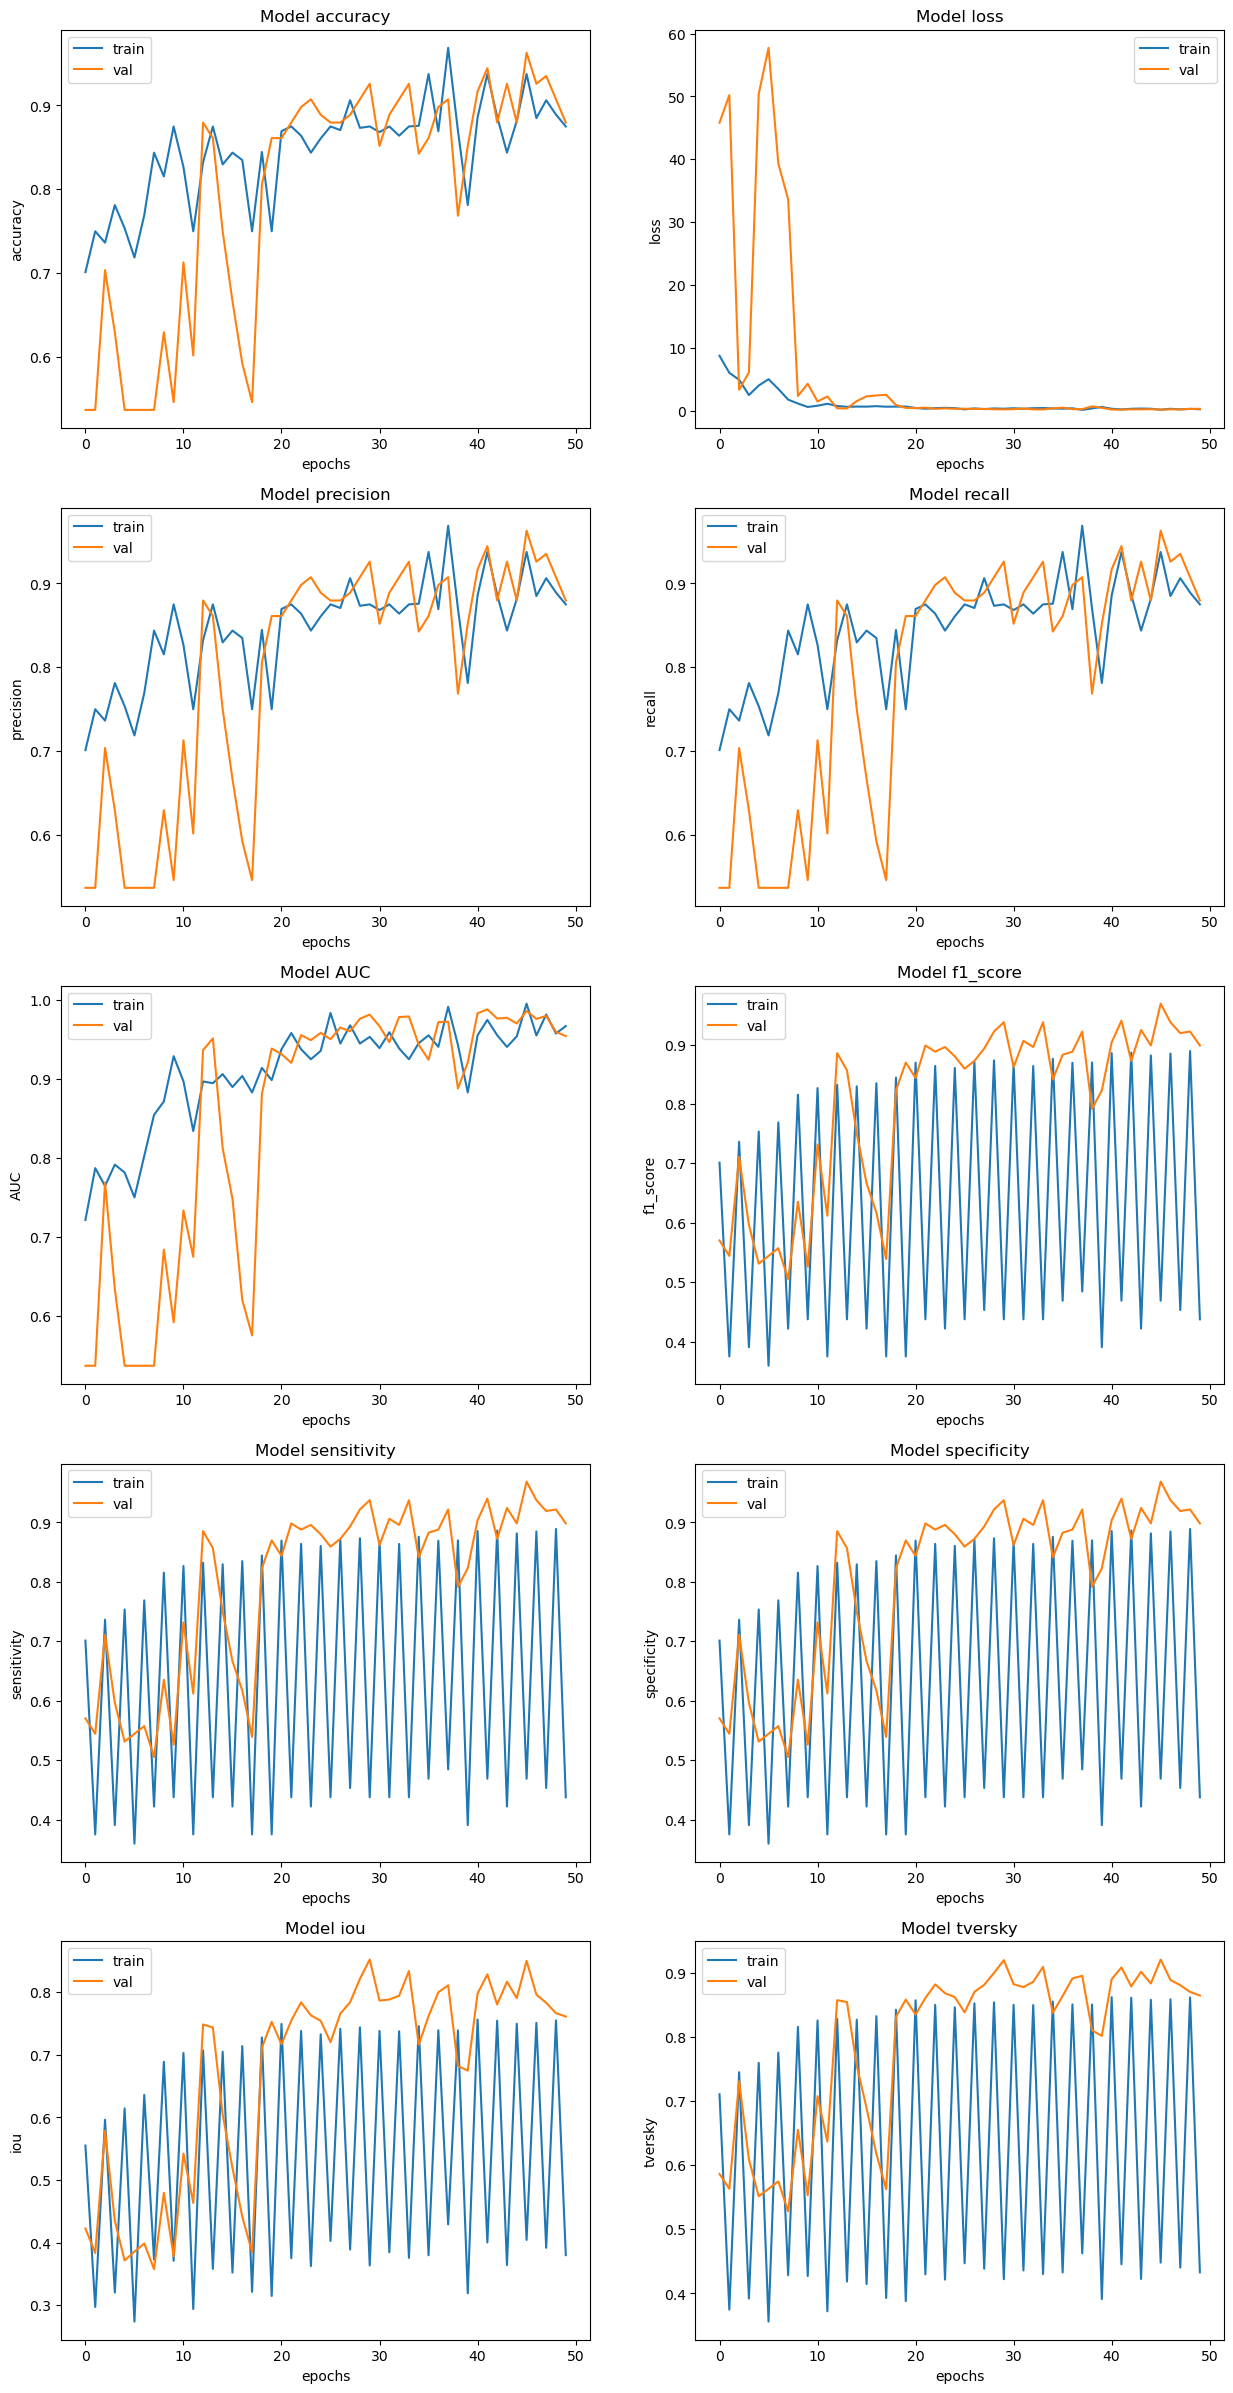

In [54]:
# Interpreting the Metrics
fig, ax = plt.subplots(5, 2, figsize=(15, 30))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss', 'precision', 'recall', 'AUC', 'f1_score', 'sensitivity', 'specificity', 'iou', 'tversky']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model-Results.png")

Test_data = (data_gen.flow(X2_test, Y_test,
                          batch_size=32,  # Reduced batch size to 32
                          seed=27,
                          shuffle=True))

In [56]:
# EvaluatING the model on the test data
print("Evaluate on test data")
results = model.evaluate(Test_data, batch_size=16, callbacks=callbacks)  # Reduced batch size to 16
print("test loss test acc:", results)

truey = []
predy = []
x = X2_test
y = Y_test

yhat = model.predict(x)
yh = yhat.tolist()
yt = y.tolist()
count = 0

for i in range(len(y)):
    yy = max(yh[i])
    yyt = max(yt[i])
    predy.append(yh[i].index(yy))
    truey.append(yt[i].index(yyt))
    if(yh[i].index(yy) == yt[i].index(yyt)):
        count += 1

acc = (count / len(y)) * 100


Evaluate on test data


2024-07-25 01:05:47.564677: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - AUC: 0.9617 - accuracy: 0.8954 - f1_score: 0.8954 - iou: 0.7545 - loss: 0.2504 - precision: 0.8954 - recall: 0.8954 - sensitivity: 0.8954 - specificity: 0.8954 - tversky: 0.8596
test loss test acc: [0.2557230293750763, 0.8904810547828674, 0.8904810547828674, 0.8904810547828674, 0.9611002206802368, 0.8912476301193237, 0.8912476301193237, 0.8912476301193237, 0.7535489201545715, 0.8595836758613586]


2024-07-25 01:05:53.000001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step


2024-07-25 01:05:58.232087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


In [58]:
# Saving values for confusion matrix and analysis
np.save('truey', truey)
np.save('predy', predy)
print("Predicted and true label values saved")
print("Accuracy on test set :" + str(acc) + "%")

Predicted and true label values saved
Accuracy on test set :91.40225179119754%


[[469  53]
 [ 31 424]]


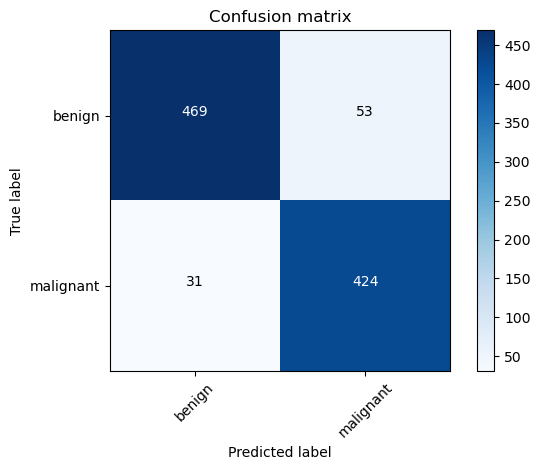

In [60]:
# Plot confusion matrix
confusion_matrix_img(truey, predy, savename='Confusion Matrix')

In [62]:
import pandas as pd

# Loading the training history
df = pd.read_excel('output.xlsx')


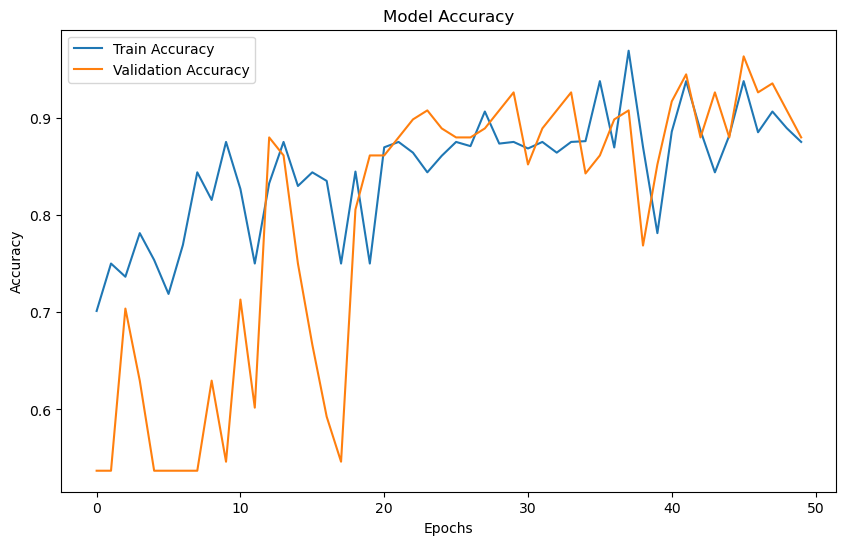

In [64]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(df['accuracy'], label='Train Accuracy')
plt.plot(df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()


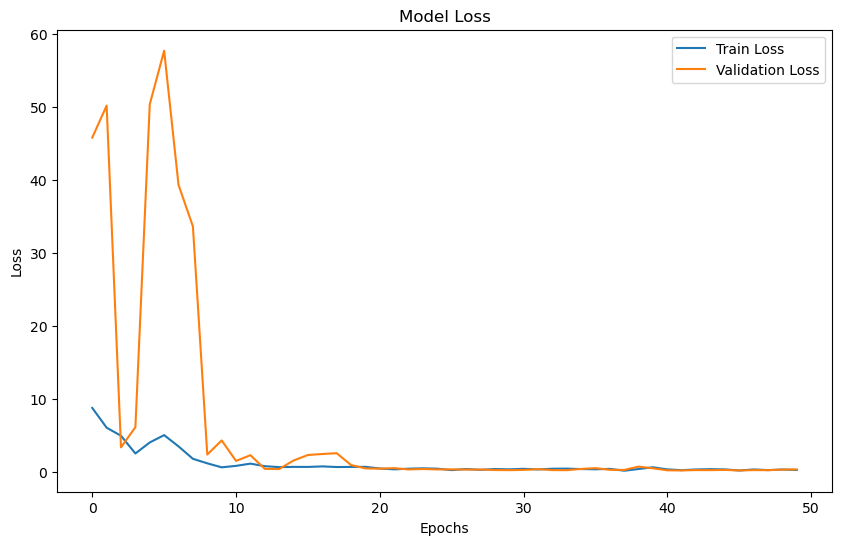

In [66]:
# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(df['loss'], label='Train Loss')
plt.plot(df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

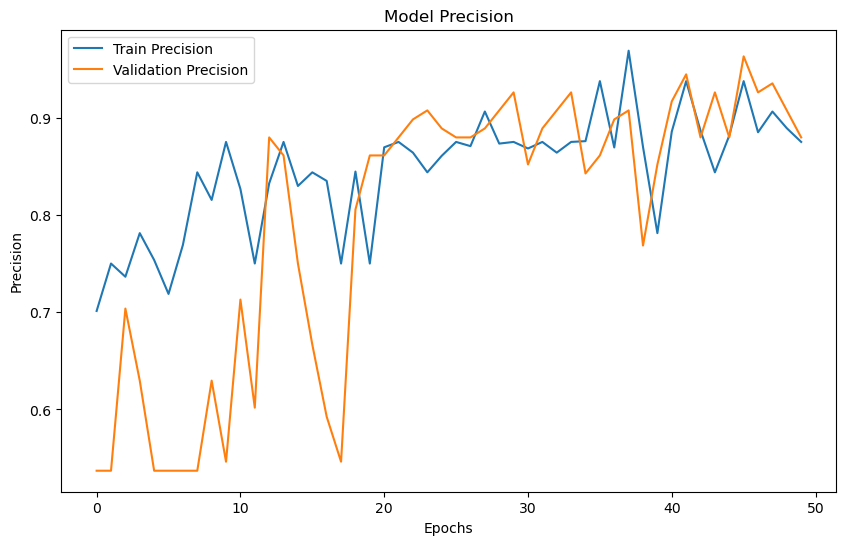

In [68]:
# Plot precision
plt.figure(figsize=(10, 6))
plt.plot(df['precision'], label='Train Precision')
plt.plot(df['val_precision'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Model Precision')
plt.legend()
plt.show()

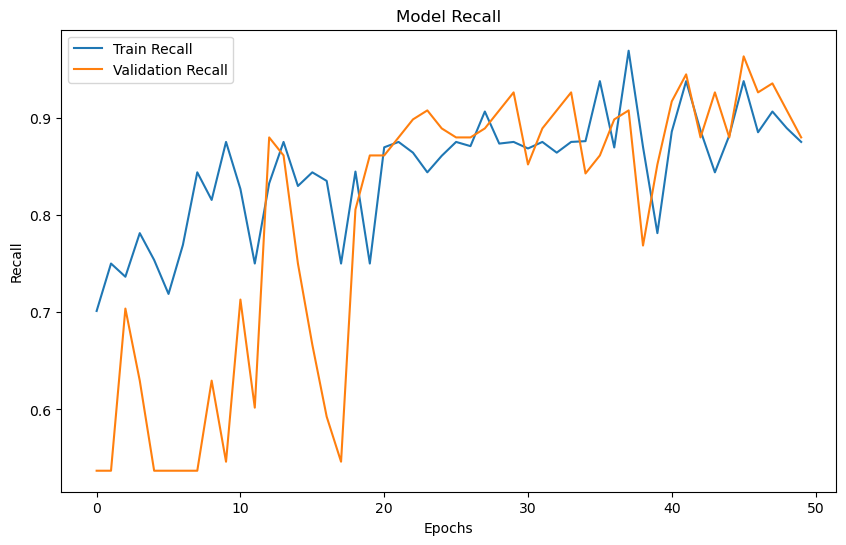

In [70]:
# Plot recall
plt.figure(figsize=(10, 6))
plt.plot(df['recall'], label='Train Recall')
plt.plot(df['val_recall'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Model Recall')
plt.legend()
plt.show()


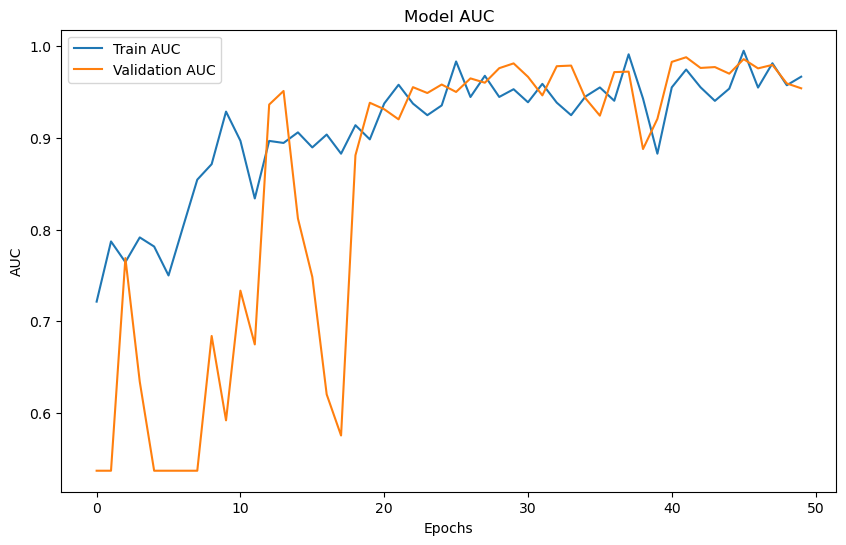

In [72]:
# Plot AUC
plt.figure(figsize=(10, 6))
plt.plot(df['AUC'], label='Train AUC')
plt.plot(df['val_AUC'], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Model AUC')
plt.legend()
plt.show()


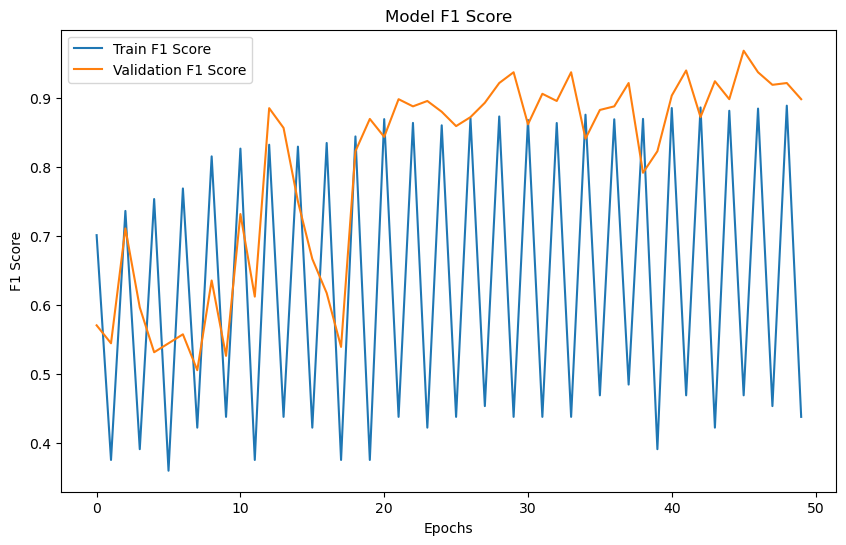

In [74]:
# Plot F1 Score
plt.figure(figsize=(10, 6))
plt.plot(df['f1_score'], label='Train F1 Score')
plt.plot(df['val_f1_score'], label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Model F1 Score')
plt.legend()
plt.show()

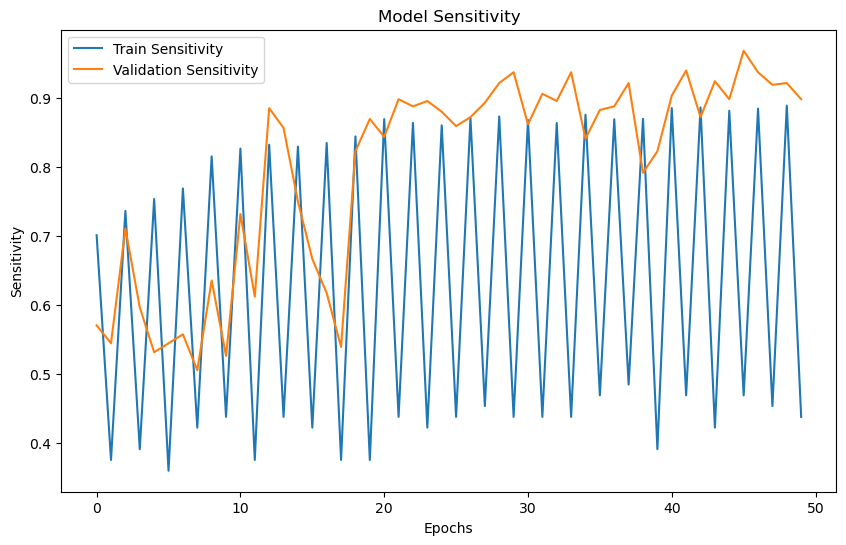

In [76]:
# Plot sensitivity
plt.figure(figsize=(10, 6))
plt.plot(df['sensitivity'], label='Train Sensitivity')
plt.plot(df['val_sensitivity'], label='Validation Sensitivity')
plt.xlabel('Epochs')
plt.ylabel('Sensitivity')
plt.title('Model Sensitivity')
plt.legend()
plt.show()

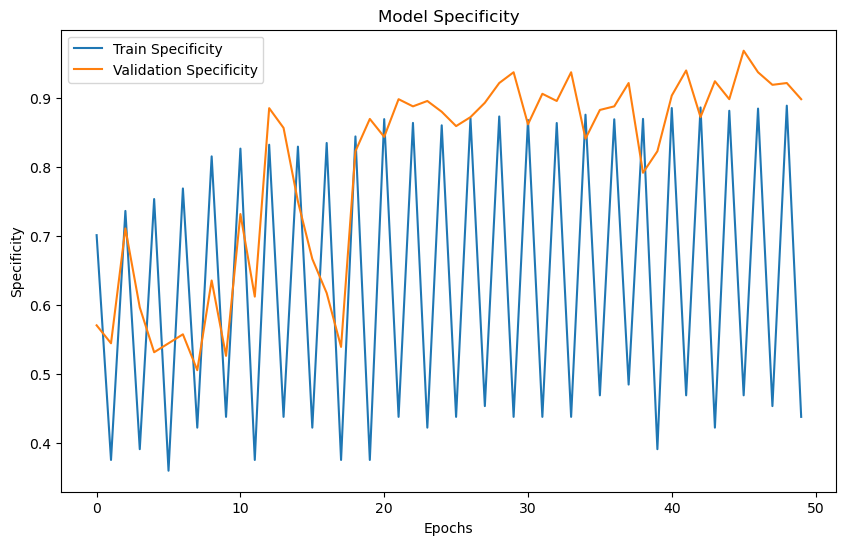

In [78]:
# Plot specificity
plt.figure(figsize=(10, 6))
plt.plot(df['specificity'], label='Train Specificity')
plt.plot(df['val_specificity'], label='Validation Specificity')
plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.title('Model Specificity')
plt.legend()
plt.show()


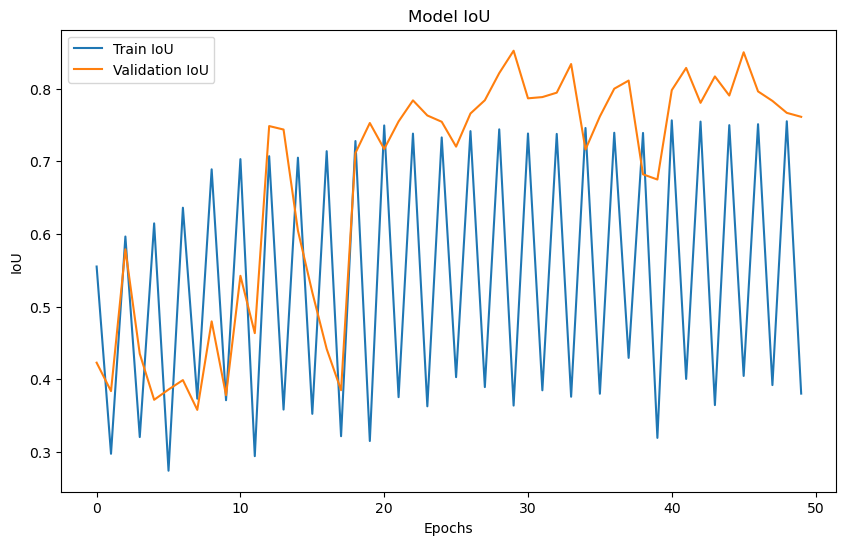

In [80]:
# Plot IoU
plt.figure(figsize=(10, 6))
plt.plot(df['iou'], label='Train IoU')
plt.plot(df['val_iou'], label='Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Model IoU')
plt.legend()
plt.show()


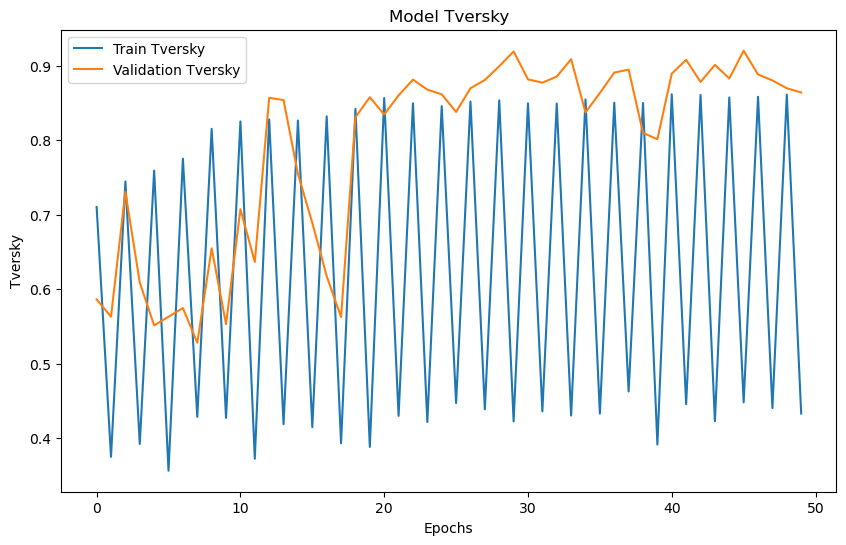

In [82]:
# Plot Tversky
plt.figure(figsize=(10, 6))
plt.plot(df['tversky'], label='Train Tversky')
plt.plot(df['val_tversky'], label='Validation Tversky')
plt.xlabel('Epochs')
plt.ylabel('Tversky')
plt.title('Model Tversky')
plt.legend()
plt.show()


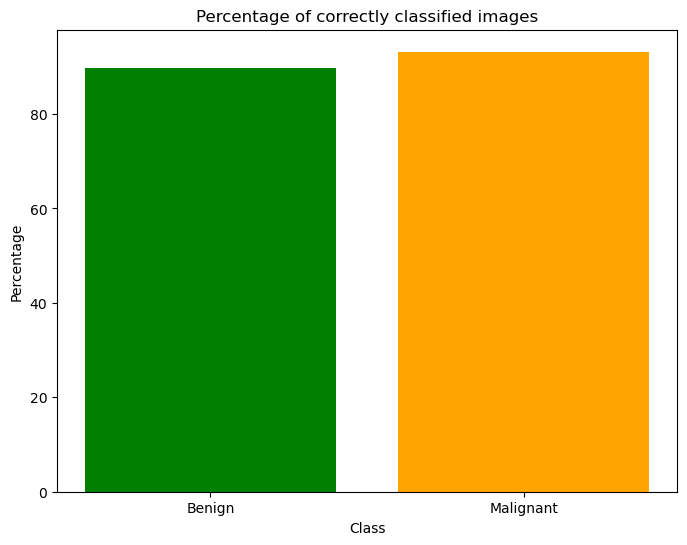

In [86]:
import matplotlib.pyplot as plt

# Calculated accuracies from the confusion matrix
accuracy_benign = 89.8  # Accuracy for the benign images
accuracy_malignant = 93.2  # Accuracy for the malignant images

categories = ['Benign', 'Malignant']
accuracies = [accuracy_benign, accuracy_malignant]
colors = ['green', 'orange']

# Bar plot
plt.figure(figsize=(8, 6))
plt.bar(categories, accuracies, color=colors)

# Title and labels
plt.title('Percentage of correctly classified images')
plt.xlabel('Class')
plt.ylabel('Percentage')

plt.show()


In [90]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Dense, Flatten, LeakyReLU, Embedding, multiply, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os

In [ ]:

# Print TensorFlow and Keras versions
print(tf.__version__)
print(tf.keras.__version__)

# Set image shape and noise dimension
size = 128
img_shape = (size, size, 3)
noise_dim = 100
num_classes = 2

# Build the generator
def build_generator(noise_dim, num_classes, img_shape):
    noise = Input(shape=(noise_dim,))
    label = Input(shape=(1,), dtype='int32')
    
    label_embedding = Flatten()(Embedding(num_classes, noise_dim)(label))
    model_input = multiply([noise, label_embedding])
    
    x = Dense(256)(model_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(np.prod(img_shape), activation='tanh')(x)
    img = Reshape(img_shape)(x)
    
    return Model([noise, label], img)

generator = build_generator(noise_dim, num_classes, img_shape)

# Assume the generator has been trained as per your previous code

# Load and preprocess the dataset
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

# Define paths
benign_path = '/Users/renitalewis/Downloads/archive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign'
malignant_path = '/Users/renitalewis/Downloads/archive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant'

# Get list of files
benign_images = getListOfFiles(benign_path)
malignant_images = getListOfFiles(malignant_path)

# Prepare the DataFrame
total_images = len(benign_images) + len(malignant_images)
data = pd.DataFrame(index=np.arange(0, total_images), columns=["image", "target"])

k = 0
for c, image_list in enumerate([benign_images, malignant_images]):
    for image_path in image_list:
        if image_path.endswith('.png'):
            data.loc[k, "image"] = image_path
            data.loc[k, "target"] = c
            k += 1

# Resample to balance the dataset
ben_upsampled = resample(data[data['target'] == 0], n_samples=data[data['target'] == 1].shape[0], random_state=42)
up_sampled = pd.concat([data[data['target'] == 1], ben_upsampled])

# Load images
train_image = []
y = []

for i in range(up_sampled.shape[0]):
    img = load_img(up_sampled['image'].iloc[i], target_size=(size, size), color_mode='rgb')
    img = img_to_array(img)
    img = img / 255.0
    train_image.append(img)
        
X = np.array(train_image)
y = up_sampled['target'].values

# Ensure labels are integers
y = y.astype(int)

# KFold split
kf = KFold(n_splits=10, random_state=42, shuffle=True)

for train_index, test_index in kf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

for train_index, test_index in kf.split(X_test, y_test):
    X2_test, X_val, y2_test, y_val = X_test[train_index], X_test[test_index], y_test[train_index], y_test[test_index]

# Convert labels to appropriate format for the generator
y_train_tensor = np.expand_dims(y_train, axis=-1).astype(np.int32)
y2_test_tensor = np.expand_dims(y2_test, axis=-1).astype(np.int32)

# Extract features using the generator
# Since the generator expects noise and labels, we'll pass dummy noise and actual labels
dummy_noise_train = np.zeros((X_train.shape[0], noise_dim))
dummy_noise_test = np.zeros((X2_test.shape[0], noise_dim))

X_features_train = generator.predict([dummy_noise_train, y_train_tensor])
X_features_test = generator.predict([dummy_noise_test, y2_test_tensor])

# Flatten the features
X_features_train = X_features_train.reshape(X_features_train.shape[0], -1)
X_features_test = X_features_test.reshape(X_features_test.shape[0], -1)

# SVM Classifier
svm_classifier = SVC()
svm_classifier.fit(X_features_train, y_train)
y_pred_svm = svm_classifier.predict(X_features_test)
accuracy_svm = accuracy_score(y2_test, y_pred_svm)
precision_svm = precision_score(y2_test, y_pred_svm)
recall_svm = recall_score(y2_test, y_pred_svm)
f1_svm = f1_score(y2_test, y_pred_svm)
cm_svm = confusion_matrix(y2_test, y_pred_svm)
tn, fp, fn, tp = cm_svm.ravel()
specificity_svm = tn / (tn + fp)
bac_svm = (recall_svm + specificity_svm) / 2
print("SVM Classifier")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}")
print(f"Specificity: {specificity_svm:.4f}")
print(f"BAC: {bac_svm:.4f}")

# Logistic Regression Classifier
logreg_classifier = LogisticRegression()
logreg_classifier.fit(X_features_train, y_train)
y_pred_logreg = logreg_classifier.predict(X_features_test)
accuracy_logreg = accuracy_score(y2_test, y_pred_logreg)
precision_logreg = precision_score(y2_test, y_pred_logreg)
recall_logreg = recall_score(y2_test, y_pred_logreg)
f1_logreg = f1_score(y2_test, y_pred_logreg)
cm_logreg = confusion_matrix(y2_test, y_pred_logreg)
tn, fp, fn, tp = cm_logreg.ravel()
specificity_logreg = tn / (tn + fp)
bac_logreg = (recall_logreg + specificity_logreg) / 2
print("Logistic Regression Classifier")
print(f"Accuracy: {accuracy_logreg:.4f}")
print(f"Precision: {precision_logreg:.4f}")
print(f"Recall: {recall_logreg:.4f}")
print(f"F1 Score: {f1_logreg:.4f}")
print(f"Specificity: {specificity_logreg:.4f}")
print(f"BAC: {bac_logreg:.4f}")

# Fully Connected Layers Classifier
fc_model = Sequential()
fc_model.add(Dense(512, activation='relu', input_shape=(X_features_train.shape[1],)))
fc_model.add(Dropout(0.5))
fc_model.add(Dense(512, activation='relu'))
fc_model.add(Dropout(0.5))
fc_model.add(Dense(1, activation='sigmoid'))
fc_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
fc_model.fit(X_features_train, y_train, epochs=50, batch_size=32, validation_data=(X_features_test, y2_test))
y_pred_fc = fc_model.predict(X_features_test)
y_pred_fc = (y_pred_fc > 0.5).astype(int)
accuracy_fc = accuracy_score(y2_test, y_pred_fc)
precision_fc = precision_score(y2_test, y_pred_fc)
recall_fc = recall_score(y2_test, y_pred_fc)
f1_fc = f1_score(y2_test, y_pred_fc)
cm_fc = confusion_matrix(y2_test, y_pred_fc)
tn, fp, fn, tp = cm_fc.ravel()
specificity_fc = tn / (tn + fp)
bac_fc = (recall_fc + specificity_fc) / 2
print("Fully Connected Layers Classifier")
print(f"Accuracy: {accuracy_fc:.4f}")
print(f"Precision: {precision_fc:.4f}")
print(f"Recall: {recall_fc:.4f}")
print(f"F1 Score: {f1_fc:.4f}")
print(f"Specificity: {specificity_fc:.4f}")
print(f"BAC: {bac_fc:.4f}")

# Compile the Results into a Table
results = {
    "Classifier": ["ACGAN-WGAN + SVM", "ACGAN-WGAN + Logistic Regression", "ACGAN-WGAN + Fully Connected Layers"],
    "Accuracy": [accuracy_svm, accuracy_logreg, accuracy_fc],
    "Precision": [precision_svm, precision_logreg, precision_fc],
    "Recall": [recall_svm, recall_logreg, recall_fc],
    "F1 Score": [f1_svm, f1_logreg, f1_fc],
    "Specificity": [specificity_svm, specificity_logreg, specificity_fc],
    "BAC": [bac_svm, bac_logreg, bac_fc]
}

results_df = pd.DataFrame(results)
print(results_df)
